# Modeling and Evaluation with scikit-learn

This lecture is a fast-pace study of the supervised learning algorithms and associated performance evaluation metrics available in the `scikit-learn` package, the go-to package for traditional machine learning in Python. 
+ ***I assume that you are already experienced with supervised learning with other tools***, e.g., R. Otherwise, this lecture will be difficult as I won't cover the underlying theory of supervised learning.

On top of studying Python/scikit-learn-based predictive analytics, we put an emphasize on the following advanced topics:
+ understanding when and how to choose between all the available algorithms,  
+ understanding when and how to choose between all the available performance metrics,
+ and some in-depth discussion on the relationship between data wrangling and model performance.

This lecture is divided into four parts:
+ (Part 1) How to conduct supervised learning using the `scikit-learn` package. 
+ (Part 2) A walk-through of several popular supervised learning algorithms.
+ (Part 3) Various performance metrics: why many, and when to use each
+ (Part 4) Several focused discussions on data wrangling and model performance
    + Imputation
    + Unbalanced data
    + Data standardization/normalization   

# Part 1: Supervised learning using scikit-learn -- the basic flow

Let's go through the basic flow of modeling and evaluation in scikit-learn (which we briefly tried earlier in Lecture 2). Let's use the pre-processed Titanic dataset "titanic_train_preprocessed.csv", and the familiar logistic regression model.  

In [1]:
# Load necessary packages
import numpy as np
import pandas as pd
pd.set_option('max_columns', 50)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
# Load the pre-processed Titanic dataset. Note that we've already addressed 
# some (but not all) data problems in this dataset via data wrangling. We will
# do more data wrangling later to see how it affects model performance.
df = pd.read_csv('titanic_train_preprocessed.csv')
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q
0,0,3,1,22.0,1,0,7.2500,0,0
1,1,1,0,38.0,1,0,71.2833,1,0
2,1,3,0,26.0,0,0,7.9250,0,0
3,1,1,0,35.0,1,0,53.1000,0,0
4,0,3,1,35.0,0,0,8.0500,0,0


In [3]:
# Separate the data into the feature matrix and the target array
X = df.drop(columns=['Survived'])
y = df['Survived']

# Next, split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                               test_size=0.2, # reserve 20% data for testing
                               random_state=365) #random_state: 1-100 one of it may give best result---data leakage

# (Not required in our class) The following is to avoid the well-known SettingWithCopyWarning
# associated with the problematic implementation of train_test_split()
X_train = X_train.copy()
X_test = X_test.copy()

print(X_train.shape)
print(X_test.shape)

(712, 8)
(179, 8)


In [4]:
# This dataset has missing values in column Age, which we need to impute first
X_train_Age_mean = X_train['Age'].mean() #age have 177 missing values--find out average value to temporary variable
X_train['Age'] = X_train['Age'].fillna(X_train_Age_mean)

# Verify that there's no more missing values:
X_train.Age.isna().sum()

0

In [5]:
# Important: make sure to do exactly the same data wrangling over the test dataset!
X_test['Age'] = X_test['Age'].fillna(X_train_Age_mean)
#training/test mean both are fine, but do not take average value for the whole dataset--test data have to be separated from training data
#data leakage: randomly cut data, the way of cutting data give better results--pure luck

In [6]:
# Let's again try logistic regression as the learning algorithm
# First, load the package
from sklearn.linear_model import LogisticRegression

In [7]:
# Next, set the hyperparameters of this classifier
clf_lr = LogisticRegression(
    penalty='none', # Otherwise regularization will happen (to study later)
    max_iter=1000) # The model didn't converge with default 100 iterations

In [8]:
# Next, fit (a.k.a. train) this model over the train dataset
clf_lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000, penalty='none')

In [9]:
# Run this code cell to observe the coefficients of the trained model:
coef_lr = pd.DataFrame(clf_lr.coef_[0],index=X_train.columns,columns=['coefficient'])
coef_lr.transpose()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q
coefficient,-0.994477,-2.602856,-0.031945,-0.345805,-0.05967,0.003384,0.247209,0.343902


In [10]:
np.exp(coef_lr)

,coefficient
Pclass,0.369917
Sex,0.074062
Age,0.968560
SibSp,0.707650
Parch,0.942075
Fare,1.003389
Embarked_C,1.280446
Embarked_Q,1.410440


One weakness of the scikit-learn package, as compared to R packages, is that it is more into prediction and less into the completeness of statistics reporting. For example, `LogisticRegression` does not report the p-value. If you need it, try another package `statsmodels` as follows:

In [11]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,sm.add_constant(X_train))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.452236
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      703
Method:                           MLE   Df Model:                            8
Date:                Wed, 02 Mar 2022   Pseudo R-squ.:                  0.3193
Time:                        14:50:20   Log-Likelihood:                -321.99
converged:                       True   LL-Null:                       -473.03
Covariance Type:            nonrobust   LLR p-value:                 1.491e-60
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2980      0.577      7.446      0.000       3.167       5.429
Pclass        -0.9946      0.

C:\Users\monas\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
# Now back to LogisticRegression in scikit-learn. Let's evaluate the performance of the 
# trained model. To do so, we first use the trained model to predict the test dataset.
y_predict = clf_lr.predict(X_test)

In [16]:
clf_lr.predict_proba(X_test)[0:5] #the second column is the probability of survive, row is each person

array([[0.12107166, 0.87892834],
       [0.76697034, 0.23302966],
       [0.90407959, 0.09592041],
       [0.74773211, 0.25226789],
       [0.93510124, 0.06489876]])

In [13]:
# Then, compare the predicted values with the truth to get accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict).round(4)

0.8156

In [14]:
# Observe the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_predict))

[[96 12]
 [21 50]]


# Part 2: A walk-through of several popular supervised learning algorithms in scikit-learn

When it comes to creating a trained algorithm (a.k.a., a trained model, or model), we know ***there are many possible choices:*** 
+ ***There are many learning algorithms to choose from.*** 
    + E.g., regression, trees, kNN, SVM, neural network, emsemble, ...
+ Also importantly, ***most learning algorithms have hyperparameters that need to be set before training.*** The choices of these **hyperparameters** may result in different trained models.
    + E.g., for decision tree learning, how deep to allow a tree to grow? For regression, should we consider regularization? For kNN, what value of k to set? ...

***There is no free lunch*** -- there is no sure choice that dominates all other choices. Otherwise, we wouldn't see all these choices in today's analytics practices. 

In this lecture, we will try and discuss the pros/cons of a few popular learning algorithms. We leave the topic of hyperparameter tuning, as well as the discussion of the state-of-the-art boosting-based algorithms (that always require hyperparameter tuning), to the next lecture.

***One huge advantage of the `scikit-learn` package is its consistency in coding:*** once you know how to code one supervised learning algorithm, you basically know how to code all others as they share the same coding structure -- you just need to swap in the new learning algorithm.

Let's implement a few popular learning algorithms.

## Logistic Regression

For each model, scikit-learn provides documentation on both the ***underlying theory*** and the ***code implementation***. For example, for the logistic regression model:
+ See (https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) for the theory (which is a part of the [scikit-learn User Guide](https://scikit-learn.org/stable/user_guide.html))
    + Recall that supervised learning is divided into **classification** when the target variable is discrete, and **regression** when the targer variable is continuous. For this lecture, we stay with classification.
+ And see (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for the code implementation (which is a part of the [scikit-learn API Reference](https://scikit-learn.org/stable/modules/classes.html))

Earlier in this lecture we have already implemented the logistic regression model. Below I re-organize the above code (only the model related parts) into a template for ease of adaption (to other algorithms).

In [17]:
# A template for implementing various supervised learning algorithms 
# I assume that, prior to runnign this code, we have already pre-processed the data

# Load the learning algorithm
from sklearn.linear_model import LogisticRegression

# Set the hyperparameters of this algorithm
clf = LogisticRegression(penalty='none', max_iter=1000)

# Fit the model over the train data
clf.fit(X_train,y_train)

# Use the fitted model to predict the test data
y_predict = clf.predict(X_test)

# Obtain performance metrics
accuracy = accuracy_score(y_test, y_predict).round(4)
print(f"The accuracy is: {accuracy:.2%}")
print("The confusion matrix is:")
cm = confusion_matrix(y_test, y_predict)
print(cm)

# Save the model and the performance metrics for later comparison.
# Here I use suffix "lr" because we just tried logistic regression.
# Change the suffix when you switch to a new learning algorithm!
clf_lr = clf
accuracy_lr = accuracy
cm_lr = cm

The accuracy is: 81.56%
The confusion matrix is:
[[96 12]
 [21 50]]


Now let's modify the above template to implement a few other popular learning algorithms. 

## k-Nearest Neighbors (kNN)

We will build a kNN model by, sequentially:
+ Read the [scikit-learn user guide on kNN](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)
+ Decide on the particular [classifier to use](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
    + And carefully read the sample code for this classifier
+ Make a copy of the above code template into the empty code cell below
+ Then make proper modifications to the template to accomplish this exercise
    + Edit/remove the comments along the way

In [18]:
# Let's try to build a kNN model, name it "clf_knn". 

# Load the learning algorithm
from sklearn.neighbors import KNeighborsClassifier

# Set the hyperparameters of this algorithm
clf = KNeighborsClassifier(n_neighbors=3)

# Fit the model over the train data
clf.fit(X_train,y_train)

# Use the fitted model to predict the test data
y_predict = clf.predict(X_test)

# Obtain performance metrics
accuracy = accuracy_score(y_test, y_predict).round(4)
print(f"The accuracy is: {accuracy:.2%}")
print("The confusion matrix is:")
cm = confusion_matrix(y_test, y_predict)
print(cm)

# Save the model and the performance metrics for later comparison.
# Here I use suffix "lr" because we just tried logistic regression.
# Change the suffix when you switch to a new learning algorithm!
clf_knn = clf
accuracy_knn = accuracy
cm_knn = cm











The accuracy is: 70.95%
The confusion matrix is:
[[92 16]
 [36 35]]


In [ ]:




# Finished version by Geng -- please DON'T read this until you've already tried building the code by yourself

from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(X_train,y_train)

y_predict = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_predict).round(4)
print(f"The accuracy is: {accuracy:.2%}")
print("The confusion matrix is:")
cm = confusion_matrix(y_test, y_predict)
print(cm)

# save the results for later comparison
clf_knn = clf
accuracy_knn = accuracy
cm_knn = cm

## Decision Trees

We are getting better at supervised learning in scikit-learn. Next, try to build a decision tree model. Try to find needed information at (https://scikit-learn.org) by yourself. 
+ (But if you get lost, here they are: [scikit-learn user guide on decision trees](https://scikit-learn.org/stable/modules/tree.html), and [classifier to use](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).)

In [23]:
# Let's try to build a decision tree model, name it "clf_dt". 

from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier(max_depth=2) #max_depth: cut the tree
clf.fit(X_train,y_train)

y_predict = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_predict).round(4)
print(f"The accuracy is: {accuracy:.2%}")
print("The confusion matrix is:")
cm = confusion_matrix(y_test, y_predict)
print(cm)

# save the results for later comparison
clf_dt = clf
accuracy_dt = accuracy
cm_dt = cm




The accuracy is: 77.65%
The confusion matrix is:
[[104   4]
 [ 36  35]]


In [ ]:




# Finished version by Geng -- please DON'T read this until you've already tried by yourself

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train,y_train)

y_predict = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_predict).round(4)
print(f"The accuracy is: {accuracy:.2%}")
print("The confusion matrix is:")
cm = confusion_matrix(y_test, y_predict)
print(cm)

# save the results for later comparison
clf_dt = clf
accuracy_dt = accuracy
cm_dt = cm

### Plotting the trained tree

***One advantage of decision tree learning is that the trained model is often intuitive to human beings.*** Therefore, despite its often inferior performance especially for large and complicated datasets, analysts use it a lot in practice for understanding the data and for communication with others. Let's plot the trained tree I just got.

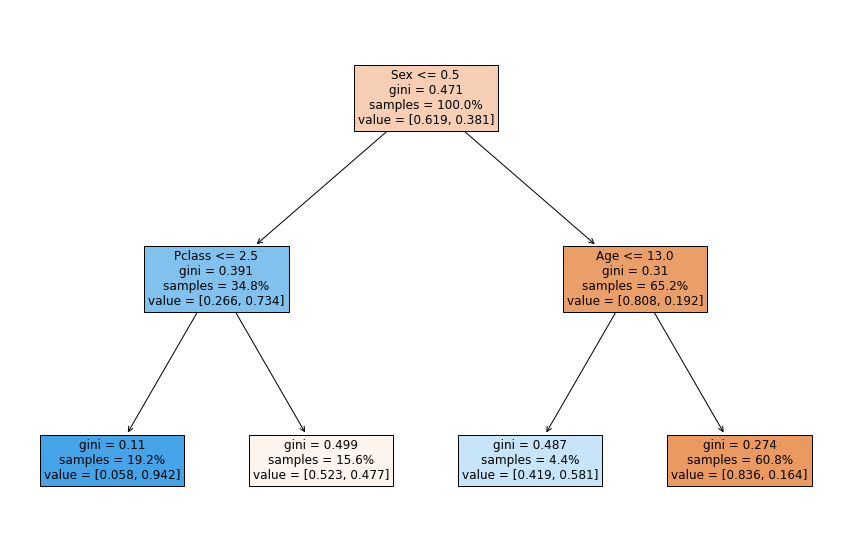

In [21]:
# warning: if the tree is too big to read, limit the max_depth of the tree during training

from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))  # set plot size (denoted in inches)
tree.plot_tree(clf_dt,
               feature_names=X_train.columns,
               filled = True,
               proportion=True,
               fontsize=12)
plt.show()

## Random Forests

In terms of predictive performance, ensemble methods, especially boosting-based algorithms, are the frequent champions when big and complex datasets are concerned.
+ Except for deep learning where deep neural networks are the king.

We will study boosting-based algorithms in more details in the next lecture. Here, let's implement one of the most popular and easy-to-use emsemble method, the **Random Forests**. Again, read the user guide including API guide of Random Forests at (https://scikit-learn.org) before you proceed.

Next, let's build a random forest model.

Hint: start by reading the according [scikit-learn user guide on random forest](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)

In [25]:
# train a random forest model by yourself, name it "clf_rf"

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf.fit(X_train,y_train)

y_predict = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_predict).round(4)
print(f"The accuracy is: {accuracy:.2%}")
print("The confusion matrix is:")
cm = confusion_matrix(y_test, y_predict)
print(cm)

# save the results for later comparison
clf_rf = clf
accuracy_rf = accuracy
cm_rf = cm




The accuracy is: 83.24%
The confusion matrix is:
[[100   8]
 [ 22  49]]


In [27]:




# Finished version by Geng -- please DON'T read this until you've already tried by yourself

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train,y_train)

y_predict = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_predict).round(4)
print(f"The accuracy is: {accuracy:.2%}")
print("The confusion matrix is:")
cm = confusion_matrix(y_test, y_predict)
print(cm)

# save the results for later comparison
clf_rf = clf
accuracy_rf = accuracy
cm_rf = cm

The accuracy is: 79.33%
The confusion matrix is:
[[107   1]
 [ 36  35]]


### Using random forest for ranking the importance of features

A handy feature of RandomForestClassifier is that ***it provides a robust ranking of the relative importance of all input variables.***
+ Often subsequently used for manual feature selection.
+ Note that this ranking gets around the (messy) choice among correlated variables problem.

In [28]:
#Q: which variable most important?
#regression: which variable significant (Forward selection/backward selection)
#tree: which is top-level cut(unstable)

importances = clf_rf.feature_importances_
pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
#large dataset---this sequence should be consistent

Sex           0.322660
Fare          0.215141
Pclass        0.201329
Age           0.122027
SibSp         0.070367
Parch         0.031325
Embarked_C    0.028627
Embarked_Q    0.008524
dtype: float64

## A recap of the learning algorithms in `scikit-learn` package

The `scikit-learn` package contains a large selection of [*traditional* supervised learning algorithms](https://scikit-learn.org/stable/supervised_learning.html), with excellent documentation and coding examples. 
+ "traditional" means not using the deep learning approach

I expect you to be able to use the following learning algorithms:
+ **Linear Models** including both linear regression and logistic regression
  + For better predictive power, use Python
  + For better explanatory power, use R
+ **Decision Trees**
+ **Nearest Neighbors**
  + simple, only one hyperparameter, and can be used for imputation  
+ Ensemble methods including **random forest** and **XGBoost** (next lecture)
+ **Neural Networks** (to study in the second-half of the semester)

**(Models NOT required for this course)** It is a good idea for you to at least read a bit about the following learning algorithms:
+ Support Vector Machines -- the idea is to use a hyperplane to separate data in a high-dimensional space; was very popular before ensemble methods took off
+ Naive Bayes -- based on the Bayes' Theorem
+ Stochastic Gradient Descent (SGD) -- It provides an efficient computational approach to fitting supervised learning models, especially when the data is big. This is a core fitting method used in deep learning (where the data is almost always big).  

You should also be familiar with the concept of **regularization** that is commonly used in machine learning (see Part 4 of this lecture)
+ purpose is to control overfitting
+ two variations
  + L1 (a.k.a. Lasso) regularization 
  + L2 (a.k.a. Ridge) regularization
  + (if you use both L1 and L2, it's called Elstic-Net)